## Importing Libraries 
Notice: The code works for tensorflow version 1.2.1 as higher order gradients are implemented. We implement all the models on K80 and PropagationMethodsAttack attack MUST run on GPU (as max_pool_with_argmax is used).

In [1]:
%load_ext autoreload
%autoreload 2
from keras import backend as K
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import _pickle as pkl
import scipy.stats as stats
import tensorflow as tf

def get_session(number=None):
    config_gpu = tf.ConfigProto()
    config_gpu.gpu_options.allow_growth = True
    return tf.Session(config=config_gpu)

Using TensorFlow backend.


## Squeezenet Model:
We slightly modified https://github.com/rcmalli/keras-squeezenet to be able to change the activation function. As described in the paper for attacking integrated gradients and simple gradient saliency maps we replace ReLU activations with Softplus in our saliency loss function gradient (And the perturbed image is applied to the original ReLU network).

In [2]:
from modified_squeezenet import SqueezeNet

## Load images:
80 correctly classified imagenet images. Squeeznet accepts channel mean subtracted images and therefore we subtract the channel mean from the image.

In [3]:
from utils import dataReader
X_dic, y_dic, labels_dic = dataReader()
mean_image = np.zeros((227,227,3))
mean_image[:,:,0]=103.939
mean_image[:,:,1]=116.779
mean_image[:,:,2]=123.68
X = X_dic - mean_image #Mean Subtraction
y = y_dic

## Loading squeezenet model:

In [4]:
tf.reset_default_graph()
sess = get_session()
K.set_session(sess)
K.set_learning_phase(0)
model = SqueezeNet("relu")

## Saliency Map: (Takes a while)
The chosen propagation method's saliency map tensor is created for SqueezeNET model. As discussed in the paper, we define the saliency map to be sum equal to one. Here, we multiply the sum-one saliency map by image dimensions for avoiding very small values. Here we have only implemented the chosen propagation method's method specific to squeezenet. (For a general library of DeepLIFT method please refer to https://github.com/kundajelab/deeplift.  We used the channel mean Image as the reference image which after channel mean subtraction would be all-zero.)

In [5]:
mode = 'DeepLIFT' #One of the "DeepLIFT", "LP"(for layerwise propagation method),  
                  # or "DTD" (for deep taylor decomposition)

In [6]:
from utils import propagetion

def create_saliency_ops(sess,model,reference_image, mode):
    
    w = model.input.get_shape()[1].value
    h = model.input.get_shape()[2].value
    c = model.input.get_shape()[3].value
    num_classes = model.output.get_shape()[-1].value
    m = propagetion(w,h,c,num_classes,sess,model,reference_image,mode=mode)
    model.m = m
    if mode=='DeepLIFT':
        relevance = m[-1]* (model.input[-1]-reference_image)
    elif mode=='LP':
        relevance = m[-1] * model.input[-1]
    elif mode=='DTD':
        relevance = m[-1]
    saliency_simple= tf.reduce_sum(tf.abs(relevance), -1)
    model.saliency = w*h*tf.divide(saliency_simple, tf.reduce_sum(saliency_simple))
    model.saliency_flatten = tf.reshape(model.saliency, [w*h])

reference_image = np.zeros((227,227,3))    #Mean Subtracted Reference Image 
create_saliency_ops(sess, model, reference_image=reference_image, mode=mode)

## Test Image:
A correctly classified ImageNET image is randomly chosen.

Image Label : guinea_pig


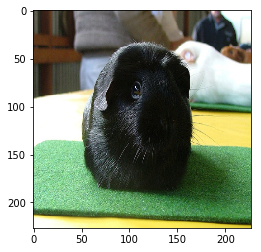

In [7]:
n = np.random.choice(80)
test_image = X[n]
original_label = y[n]
print("Image Label : {}".format(labels_dic[y[n]]))
%matplotlib inline
plt.imshow((X[n,:,:,::-1]+mean_image[:,:,::-1])/255)

## Call the perturbation module: (Creating attack directions takes a long while)
We create the attack object with our own parameters. The object is feeded with the mean subtracted image. The recommended k_top parameter for ImageNET is 1000. (Refer to the paper for description of the parameter).

In [8]:
k_top = 1000 #Recommended for ImageNet
from utils import PropagationMethodsAttack
module = PropagationMethodsAttack(mean_image, sess, test_image, original_label, NET=model, k_top=k_top)

## Attack! (Takes a while)

In [9]:
method = "mass_center" #Method should be one of "random", "mass_center", "topK", or "target"
epsilon = 8 #Maximum allowed perturbation for each pixel
output = module.iterative_attack(method, epsilon=16, alpha=0.1, iters=300, measure="mass_center")
print("The prediction confidence changes from {} to {} after perturbation.".format(module.original_confidence,
                                                                                   output[-1]))
print('''{} % of the {} most salient pixels in the original image are among {} most salient pixels of the 
perturbed image'''.format(output[0]*100,k_top,k_top))
print("The rank correlation between salieny maps is equal to {}".format(output[1]))
print("The L2 distance between mass centers of saliencies is {} pixels.".format(output[2]))

Iteration : 0
Iteration : 60
Iteration : 120
Iteration : 180
Iteration : 240
For maximum allowed perturbation size equal to 16, the resulting perturbation size was11.60000017285347
        
The prediction confidence changes from 0.9867644309997559 to 11.60000017285347 after perturbation.
9.2 % of the 1000 most salient pixels in the original image are among 1000 most salient pixels of the 
perturbed image
The rank correlation between salieny maps is equal to 0.5356668993924382
The L2 distance between mass centers of saliencies is 56.04462507680822 pixels.


## Time for depiction...

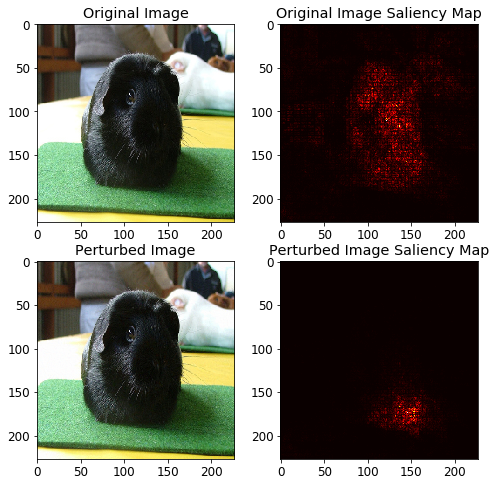

In [10]:
mpl.rcParams["figure.figsize"]=8,8
plt.rc("text",usetex=False)
plt.rc("font",family="sans-serif",size=12)
plt.subplot(2,2,1)
plt.title("Original Image")
plt.imshow((X[n,:,:,::-1]+mean_image[:,:,::-1])/255)
plt.subplot(2,2,2)
plt.title("Original Image Saliency Map")
plt.imshow(module.saliency1.clip(0, np.percentile(module.saliency1,100)),cmap="hot")
plt.subplot(2,2,3)
plt.title("Perturbed Image")
plt.imshow((module.perturbed_image[:,:,::-1]+mean_image[:,:,::-1])/255)
plt.subplot(2,2,4)
plt.title("Perturbed Image Saliency Map")
plt.imshow(module.saliency2,cmap="hot")